# 3.2 Classification and regression with a two-layer perceptron

In [1]:
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt
import seaborn as sns
from src.data import generate_binary_classification_data, generate_function_data
from src.two_layer_perceptron import TwoLayerPerceptron
from src.plotting import plot_decision_boundary, plot_learning_curve, plot_decision_boundary_tlp, plot_function_approximation
import numpy as np
import pandas as pd
from prettytable import PrettyTable
sns.set(style="white")

img_path = 'img_1_2/'

C:\virtual_environments\ml_base_venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\virtual_environments\ml_base_venv\lib\site-packages\numpy\.libs\libopenblas.2V74HQ3MKNZHDCKJELIPPY7V6QMK3UOZ.gfortran-win32.dll
C:\virtual_environments\ml_base_venv\lib\site-packages\numpy\.libs\libopenblas.U35RT5X5BPDSH5ZTF276YADQR2KDU6PR.gfortran-win32.dll
  stacklevel=1)


## 3.2.1 Classification of linearly non-separable data

Now we are ready to return to the problem of linearly non-separable patterns (the second part in section 3.1.3) with a multi-layer perceptron approach. To this end, please test a two-layer perceptron trained with backprop (the generalized Delta rule) in batch mode and examine how well it performs in separating the two classes.

### 0. Data generation

In [2]:
df = generate_binary_classification_data(
    mA=(1,1),
    sigmaA=1,
    mB=(-1, -1),
    sigmaB=1,
    classes=(1, -1),
)

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().flatten()

negative = X[(y_true == -1).flatten()]
positive = X[(y_true == 1).flatten()]

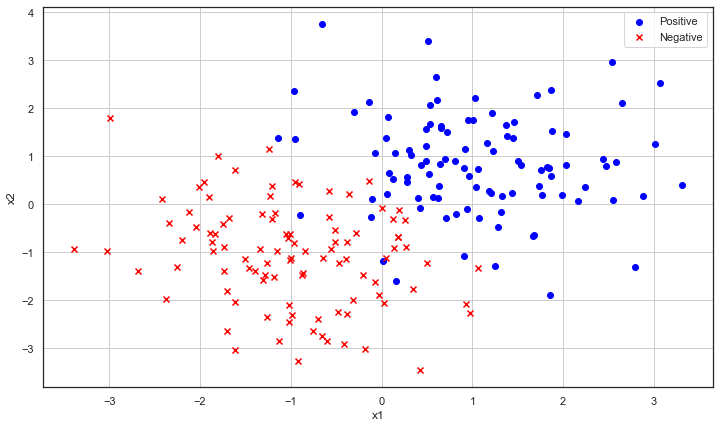

In [3]:
plot_decision_boundary(
    X=X,
    positive=positive,
    negative=negative,
    path=img_path+'dataset'
)

### 1. Vary number of hidden nodes

Modify the number of hidden nodes (just a few configurations, e.g. 3, 8, 15, 20, 30 nodes) and demonstrate the effect the size of the hidden layer has
on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?

In [4]:
num_hidden_nodes = [3, 8, 15, 20, 30]

t = PrettyTable(['Hidden Layer Size', 'MSE', 'Misc. Ratio'])

tlp = TwoLayerPerceptron(max_iterations=500)
for n_hn in num_hidden_nodes:
  tlp.hidden_layer_size = n_hn
  tlp.fit(X, y_true)
  tlp.predict(X, y_true)
  
  loss = tlp.loss_
  t.add_row([n_hn, loss['mse'], loss['missclassification_error']])
  
print(t)

+-------------------+---------------------+-------------+
| Hidden Layer Size |         MSE         | Misc. Ratio |
+-------------------+---------------------+-------------+
|         3         | 0.13884349328362366 |     0.04    |
|         8         | 0.13124480037136282 |     0.04    |
|         15        | 0.13659582018001892 |    0.045    |
|         20        |  0.1333856019961036 |    0.035    |
|         30        |  0.1320191085719012 |     0.04    |
+-------------------+---------------------+-------------+


### 2. Results with the validation set

Then, formulate this problem into a more realistic assignment where only a
subset of data points is available for training a network (data that you use
to calculate weight updates using backprop) and the remaining samples
constitute a validation dataset for probing generalisation capabilites of
the network. To do that, subsample the data in the same way as in the
second part of section 3.1.3 and the removed samples treat as a validation
set - compare two cases: 80% for training, 20% for validation and vice
versa, 20% for training and the rest for validation. Make sure you do
not use this hold-out validation set in the training process and instead
you only use it to calculate the error (mean squared error or the ratio
of misclassifications) at different stages/epochs of learning to monitor the
progress.

#### Define Help Functions

In [5]:
def train_val_split(X, y, validation_fraction):
  data = np.hstack((X, y.reshape((-1, 1))))

  np.random.shuffle(data)
  index = int(validation_fraction * data.shape[0])
  data_train, data_val = data[index:, :], data[:index, :]

  X_train, y_train = data_train[:, :-
                                1], data_train[:, -1]
  X_val, y_val = data_val[:, :-1], data_val[:, -1]
  
  return X_train, y_train, X_val, y_val

In [6]:
def run_experiment_with_validation(X_train, y_train, X_val, y_val, hidden_layer_size, validation_fraction, max_iterations=300):
  tlp = TwoLayerPerceptron(hidden_layer_size=hidden_layer_size, max_iterations=max_iterations)
  tlp.fit(X_train, y_train, X_val, y_val)
  
  plot_learning_curve(
    errors=[
        tlp.error_per_epoch['mse'], 
        tlp.error_per_epoch_val['mse']
    ],
    names=['Train', 'Validation'],
    metric='MSE',
    path='{}tlp_classification_learning_curve_mse_n_{}_v_{}_batch.png'.format(img_path, str(hidden_layer_size), str(validation_fraction*100))
  )
  
  print(
    'The MSE on the train set is {0:.4f}, and on the validation set it is {1:.4f}.'.format(
        tlp.error_per_epoch['mse'][-1],
        tlp.error_per_epoch_val['mse'][-1]
    )
  )
  
  return tlp.error_per_epoch['mse'][-1], tlp.error_per_epoch_val['mse'][-1]

def run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, hidden_layer_size, validation_fraction, max_iterations=600):
  tlp = TwoLayerPerceptron(hidden_layer_size=hidden_layer_size, max_iterations=max_iterations, is_classification_task=False)
  tlp.fit(X_train, y_train, X_val, y_val)
  
  plot_learning_curve(
    errors=[
        tlp.error_per_epoch['mse'], 
        tlp.error_per_epoch_val['mse']
    ],
    names=['Train', 'Validation'],
    metric='MSE',
    path='{}tlp_function_approx_learning_curve_mse_n_{}_v_{}_batch.png'.format(img_path, str(hidden_layer_size), str(validation_fraction*100))
  )
  
  plot_function_approximation(X_train, y_train, X_val, y_val, tlp,
                             path='{}tlp_function_approx_reg_n_{}_v_{}_batch.png'.format(img_path, str(hidden_layer_size), str(validation_fraction*100)))
  
  print(
    'The MSE on the train set is {0:.4f}, and on the validation set it is {1:.4f}.'.format(
        tlp.error_per_epoch['mse'][-1],
        tlp.error_per_epoch_val['mse'][-1]
    )
  )
  
  return tlp.error_per_epoch['mse'][-1], tlp.error_per_epoch_val['mse'][-1]

In [7]:
def plot_final_errors_per_run(val_error, train_error, labels, path=None, metric="MSE"):
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(12, 7))
  rects1 = ax.bar(x - width/2, val_error, width, label='Validation')
  rects2 = ax.bar(x + width/2, train_error, width, label='Training')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(metric)
  ax.set_title('')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  ax.bar_label(rects1, padding=3)
  ax.bar_label(rects2, padding=3)

  fig.tight_layout()
  
  if path is not None:
    plt.savefig(path)

  plt.show()

#### Train/Val Split

In [8]:
X_train, y_train, X_val, y_val = train_val_split(X, y_true, validation_fraction=0.2)
X_train_1, y_train_1, X_val_1, y_val_1 = train_val_split(X, y_true, validation_fraction=0.8)

mse_val = []
mse_val_1 = []
mse_train = []
mse_train_1 = []

#### 2.1 Learning curves for training and validation varying the number of nodes

How do the learning/error curves for the training and the validation
sets compare? How do they depend on the size of the hidden layer
and the number of training samples (80% vs 20%)? Are they similar
or in what cases do you observe more dissimilarity?

##### 3 Nodes

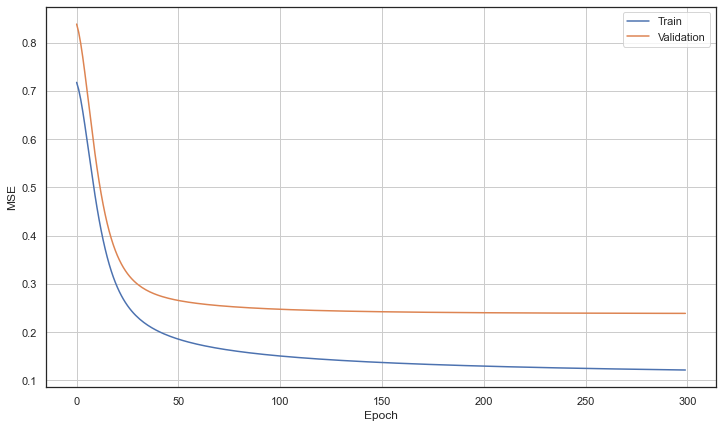

The MSE on the train set is 0.1215, and on the validation set it is 0.2389.


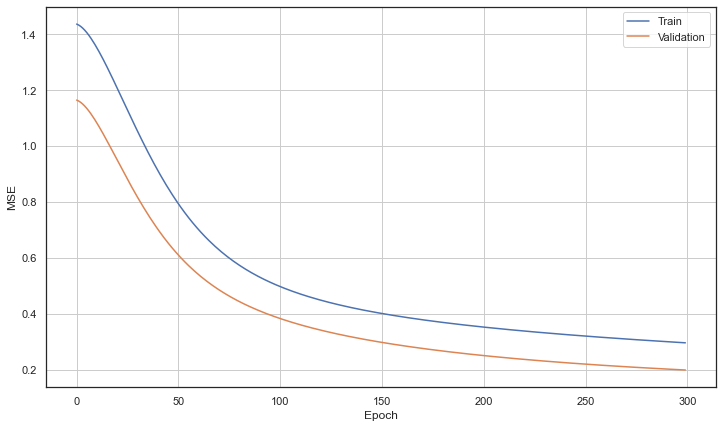

The MSE on the train set is 0.2962, and on the validation set it is 0.1990.


In [9]:
error_train, error_val = run_experiment_with_validation(X_train, y_train, X_val, y_val, 3, 0.2)
error_train_1, error_val_1 = run_experiment_with_validation(X_train_1, y_train_1, X_val_1, y_val_1, 3, 0.8)

mse_val.append(error_val)
mse_train.append(error_train)
mse_val_1.append(error_val_1)
mse_train_1.append(error_train_1)

##### 8 Nodes

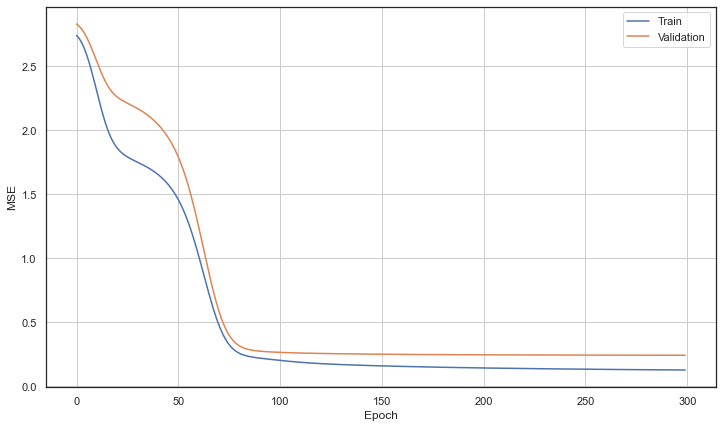

The MSE on the train set is 0.1263, and on the validation set it is 0.2414.


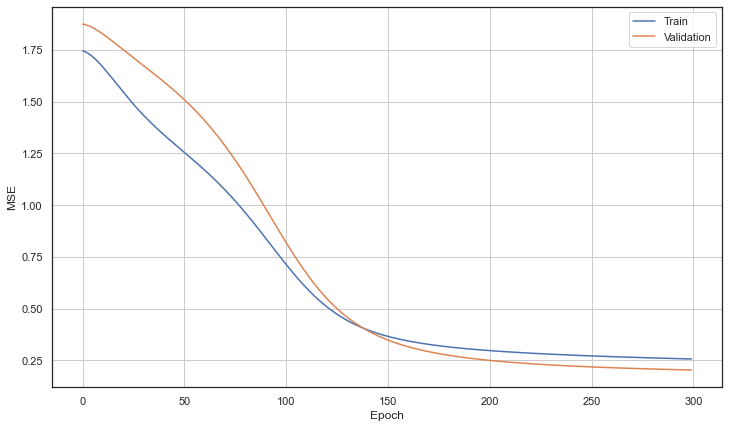

The MSE on the train set is 0.2572, and on the validation set it is 0.2041.


In [10]:
error_train, error_val = run_experiment_with_validation(X_train, y_train, X_val, y_val, 8, 0.2)
error_train_1, error_val_1 = run_experiment_with_validation(X_train_1, y_train_1, X_val_1, y_val_1, 8, 0.8)

mse_val.append(error_val)
mse_train.append(error_train)
mse_val_1.append(error_val_1)
mse_train_1.append(error_train_1)

##### 15 Nodes

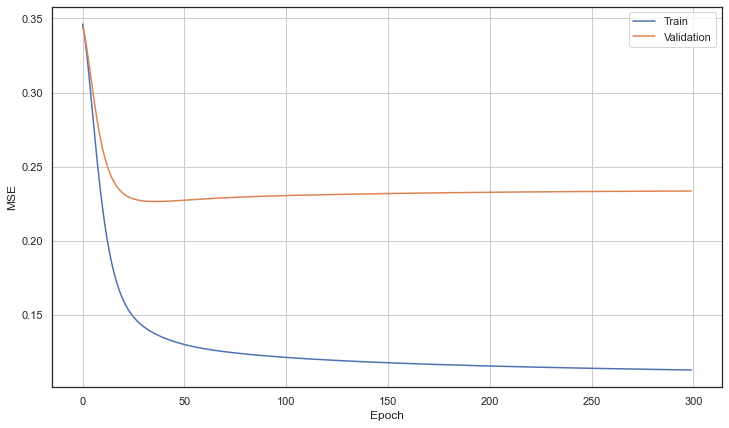

The MSE on the train set is 0.1129, and on the validation set it is 0.2336.


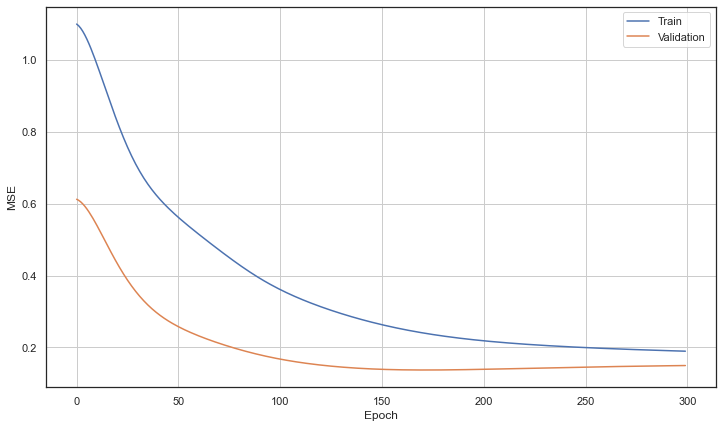

The MSE on the train set is 0.1895, and on the validation set it is 0.1495.


In [11]:
error_train, error_val = run_experiment_with_validation(X_train, y_train, X_val, y_val, 15, 0.2)
error_train_1, error_val_1 = run_experiment_with_validation(X_train_1, y_train_1, X_val_1, y_val_1, 15, 0.8)

mse_val.append(error_val)
mse_train.append(error_train)
mse_val_1.append(error_val_1)
mse_train_1.append(error_train_1)

##### 20 Nodes

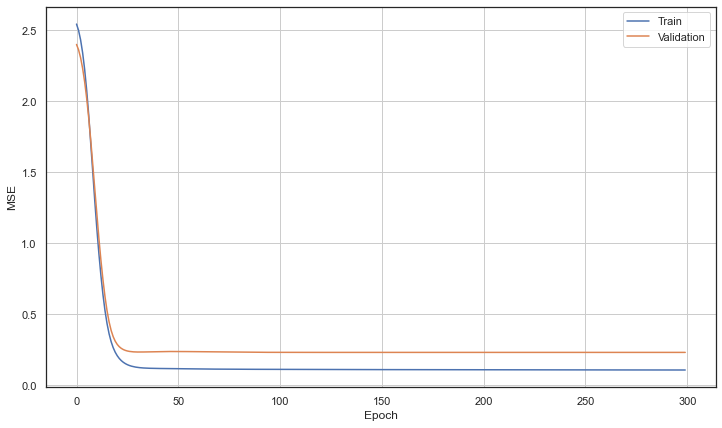

The MSE on the train set is 0.1090, and on the validation set it is 0.2330.


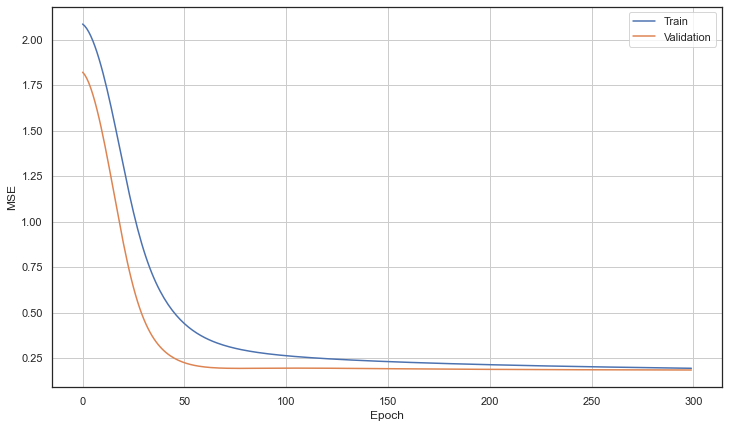

The MSE on the train set is 0.1938, and on the validation set it is 0.1844.


In [12]:
error_train, error_val = run_experiment_with_validation(X_train, y_train, X_val, y_val, 20, 0.2)
error_train_1, error_val_1 = run_experiment_with_validation(X_train_1, y_train_1, X_val_1, y_val_1, 20, 0.8)

mse_val.append(error_val)
mse_train.append(error_train)
mse_val_1.append(error_val_1)
mse_train_1.append(error_train_1)

##### 30 Nodes

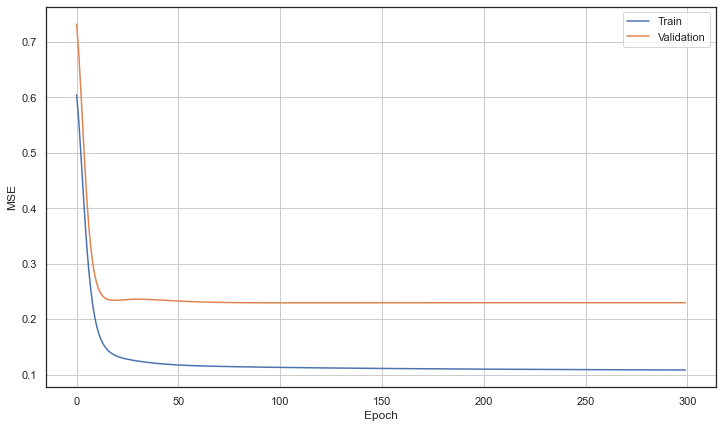

The MSE on the train set is 0.1082, and on the validation set it is 0.2294.


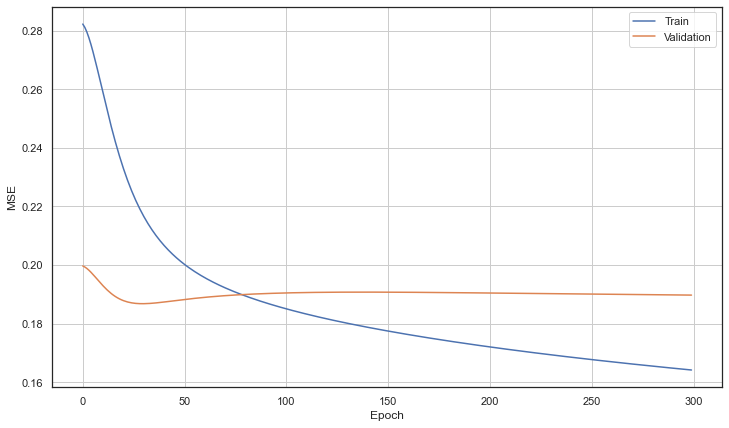

The MSE on the train set is 0.1642, and on the validation set it is 0.1897.


In [13]:
error_train, error_val = run_experiment_with_validation(X_train, y_train, X_val, y_val, 30, 0.2)
error_train_1, error_val_1 = run_experiment_with_validation(X_train_1, y_train_1, X_val_1, y_val_1, 30, 0.8)

mse_val.append(error_val)
mse_train.append(error_train)
mse_val_1.append(error_val_1)
mse_train_1.append(error_train_1)

##### Comparison

**80% Training and 20% Validation**

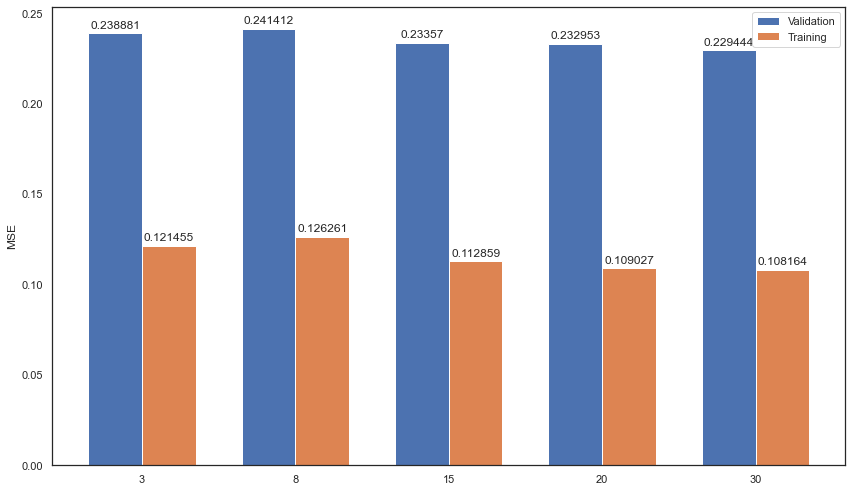

In [14]:
labels = ['3', '8', '15', '20', '30']
plot_final_errors_per_run(
  mse_val, mse_train, labels=labels, metric="MSE",
  path='{}tlp_classification_errors_per_split_mse_v_20_batch.png'.format(img_path)
)

**20% Training and 80% Validation**

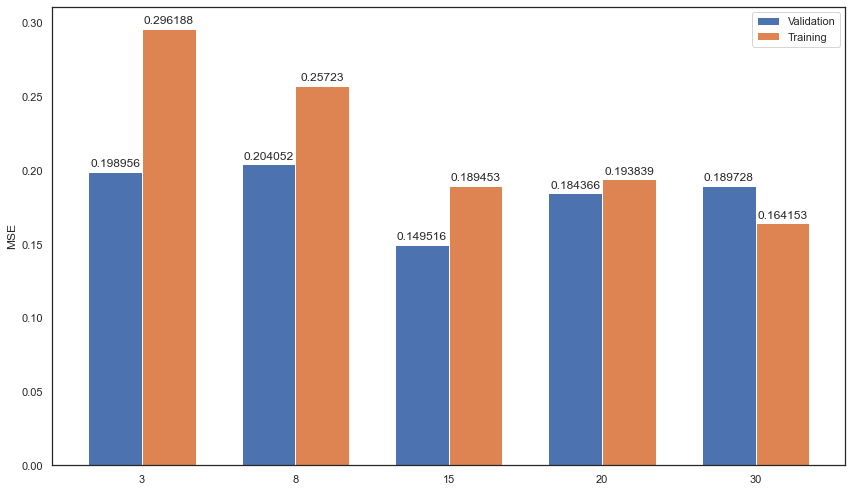

In [15]:
plot_final_errors_per_run(
  mse_val_1, mse_train_1, labels=labels, metric="MSE",
  path='{}tlp_classification_errors_per_split_mse_v_80_batch.png'.format(img_path)
)

#### 2.2 Online vs. Batch

For a selected number of hidden nodes and the case with 80% training
samples, compare a batch with sequential learning approach - is there
any difference in terms of the validation performance?

##### Validation error - Online Learning

3 nodes, online, validation MSE: 0.2476
8 nodes, online, validation MSE: 0.2171
15 nodes, online, validation MSE: 0.2393
20 nodes, online, validation MSE: 0.2579
30 nodes, online, validation MSE: 0.2323


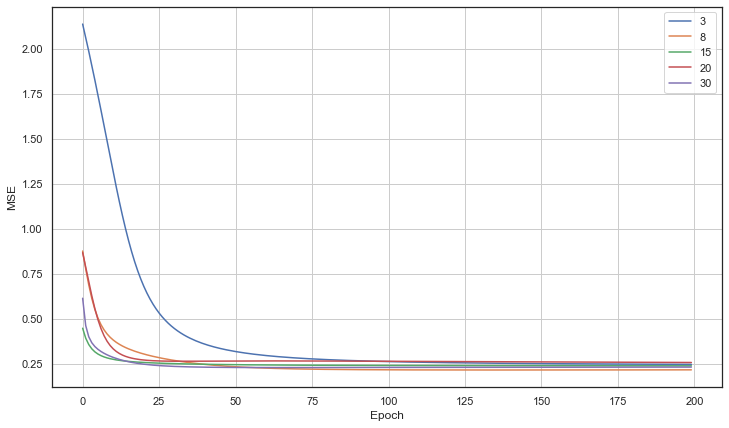

In [16]:
mse_val_online = []
tlp = TwoLayerPerceptron(mode='online', max_iterations=200)
for n_hn in num_hidden_nodes:
  tlp.hidden_layer_size = n_hn
  tlp.fit(X_train, y_train, X_val, y_val)
  
  print('{0} nodes, online, validation MSE: {1:.4f}'.format(n_hn, tlp.error_per_epoch_val['mse'][-1]))
  mse_val_online.append(tlp.error_per_epoch_val['mse'])

plot_learning_curve(
    errors=mse_val_online,
    names=labels,
    metric='MSE',
    path='{}tlp_classification_learning_curve_mse_v_20_online.png'.format(img_path)
  )

##### Validation Error - Batch Learning

3 nodes, batch, validation MSE: 0.231017
8 nodes, batch, validation MSE: 0.241094
15 nodes, batch, validation MSE: 0.249129
20 nodes, batch, validation MSE: 0.237843
30 nodes, batch, validation MSE: 0.244686


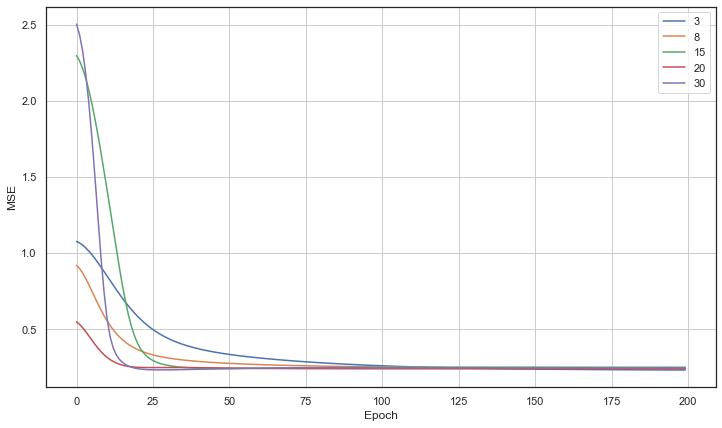

In [17]:
mse_val_batch = []

tlp = TwoLayerPerceptron(mode='batch', max_iterations=200)
for n_hn in num_hidden_nodes:
  tlp.hidden_layer_size = n_hn
  tlp.fit(X_train, y_train, X_val, y_val)
  
  print('{0} nodes, batch, validation MSE: {1:4f}'.format(n_hn, tlp.error_per_epoch_val['mse'][-1]))
  mse_val_batch.append(tlp.error_per_epoch_val['mse'])

plot_learning_curve(
    errors=mse_val_batch,
    names=labels,
    metric='MSE',
    path='{}tlp_classification_learning_curve_mse_v_20_batch.png'.format(img_path)
  )

#### 2.3 Decision Boundary

Make an attempt at approximating/visualising the resulting decision
boundary (for two networks with 3 and 30 hidden nodes, 80% training
samples), i.e. where the network output is 0 (between the target labels
of -1 and 1 for two classes, respectively).

##### 3 Nodes 80% Training

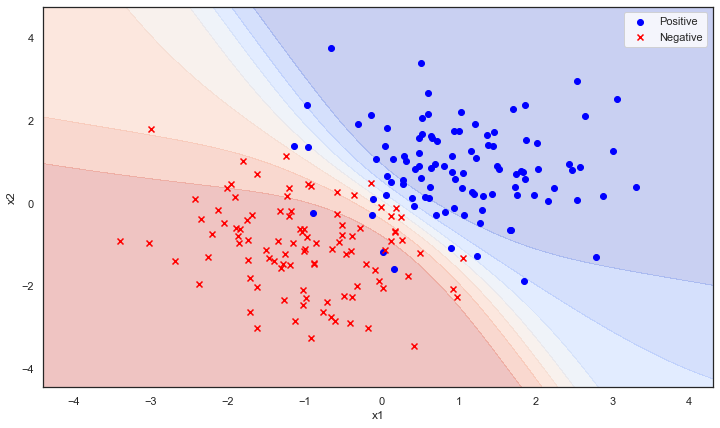

In [18]:
tlp = TwoLayerPerceptron(hidden_layer_size=3, max_iterations=300)
tlp.fit(X_train, y_train, X_val, y_val)

plot_decision_boundary_tlp(X, y_true, tlp, '{}tlp_classification_decision_boundary_n_3_v_20_batch.png'.format(img_path))

##### 30 Nodes 80% Training

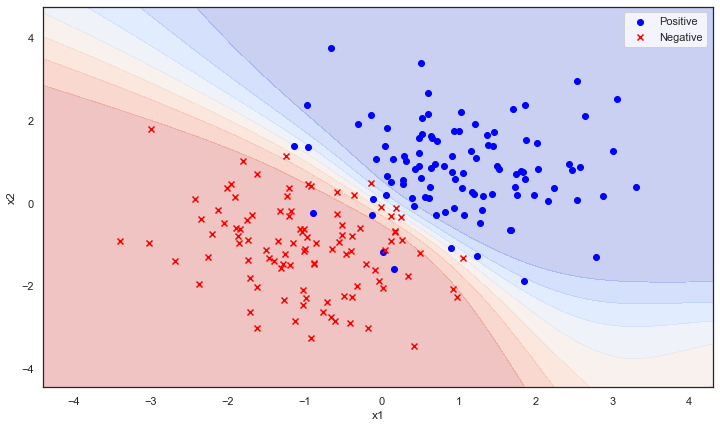

In [19]:
tlp = TwoLayerPerceptron(hidden_layer_size=30, max_iterations=300)
tlp.fit(X_train, y_train, X_val, y_val)

plot_decision_boundary_tlp(X, y_true, tlp, '{}tlp_classification_decision_boundary_n_30_v_20_batch.png'.format(img_path))

## 3.2.3 Function approximation

So far we have used the perceptron’s ability to classify data or find low-dimensional
representations. Multi-layer perceptrons are known however for their ability to
approximate an arbitrary continuous function. We will here study how one can
train a two-layer perceptron network to approximate a function based on available input-output data examples.

### 0. Data generation

In [29]:
df = generate_function_data(
    start = -5.0,
    end = 5.0,
    step = 0.5
)

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().flatten()

#### Train/Val Split

In [30]:
X_train, y_train, X_val, y_val = train_val_split(X, y_true, validation_fraction=0.2)
X_train_1, y_train_1, X_val_1, y_val_1 = train_val_split(X, y_true, validation_fraction=0.8)

### 1. Vary the number of hidden nodes

Choose 80% samples for training and the remaining 20% for validation.
Vary the number of nodes in the hidden layer, e.g. 1, 3, 5, 10, 25, and
try to observe any trends. Try to make a model comparison - what error
estimates should you use to identify the ”best” model? What happens
when you have very few (less than 5) or very many (more than 20) hidden
nodes? Can you explain your observations?

In [31]:
mse_val = []
mse_train = []
max_iter = 1000

#### 1 Node

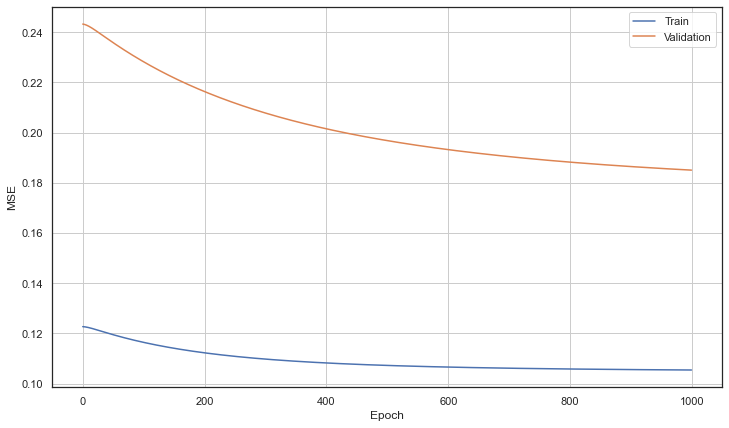

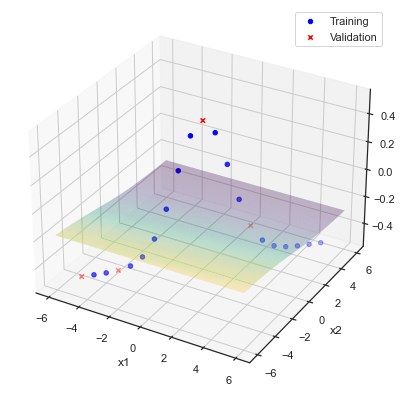

The MSE on the train set is 0.1054, and on the validation set it is 0.1851.


In [32]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, 1, 0.2, max_iterations=max_iter)

mse_val.append(error_val)
mse_train.append(error_train)

#### 3 Node

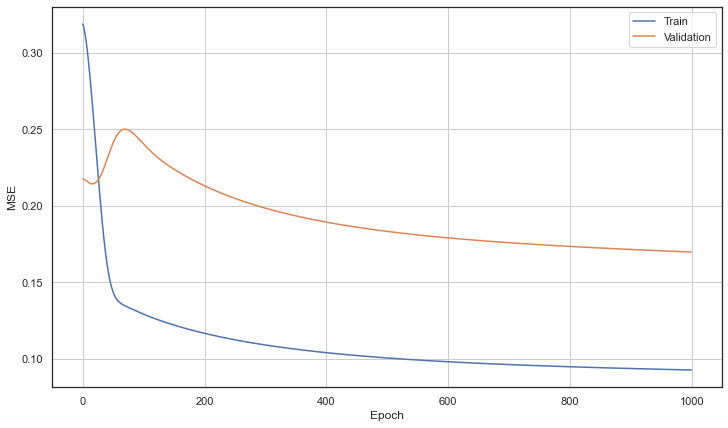

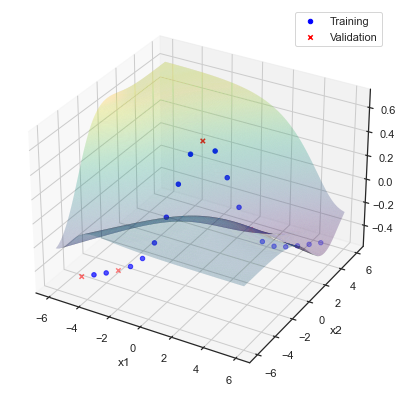

The MSE on the train set is 0.0928, and on the validation set it is 0.1698.


In [33]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, 3, 0.2, max_iterations=max_iter)

mse_val.append(error_val)
mse_train.append(error_train)

#### 5 Nodes

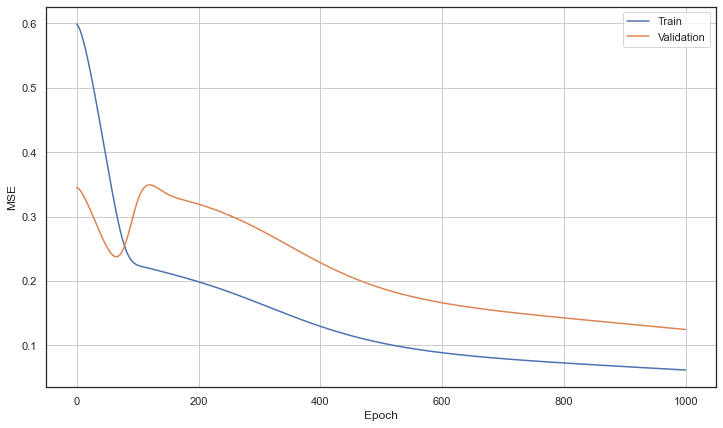

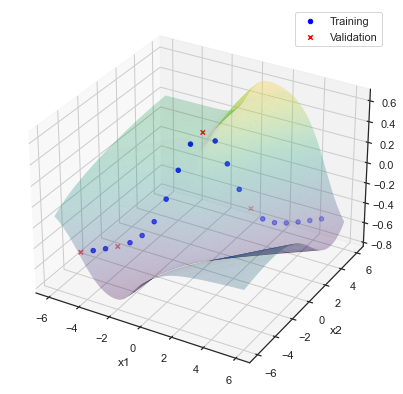

The MSE on the train set is 0.0620, and on the validation set it is 0.1248.


In [34]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, 5, 0.2, max_iterations=max_iter)

mse_val.append(error_val)
mse_train.append(error_train)

#### 10 Node

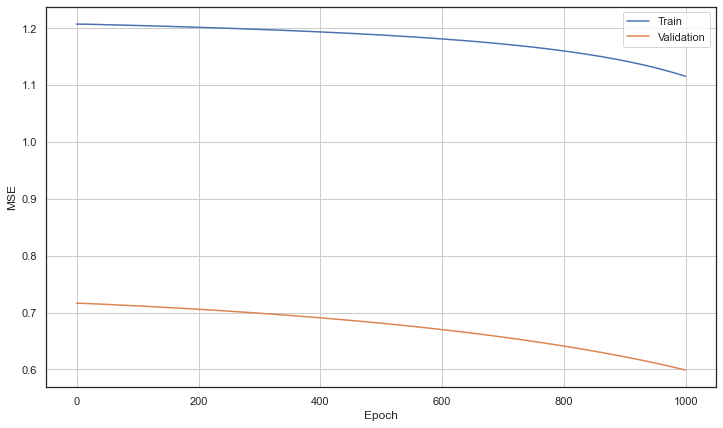

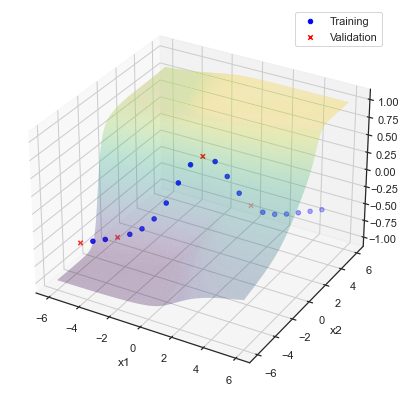

The MSE on the train set is 1.1153, and on the validation set it is 0.5989.


In [35]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, 10, 0.2, max_iterations=max_iter)

mse_val.append(error_val)
mse_train.append(error_train)

#### 25 Nodes

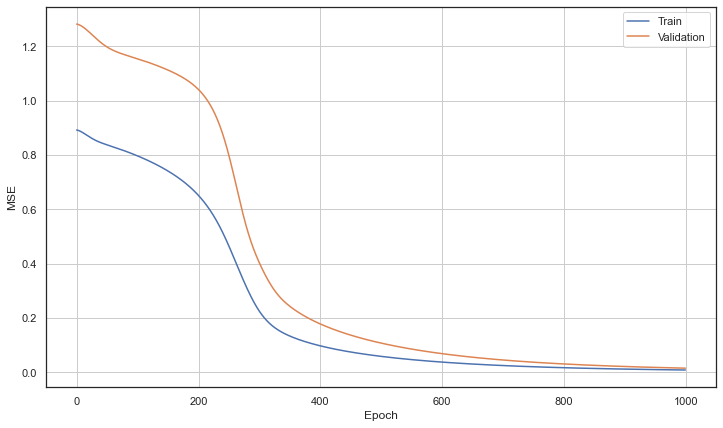

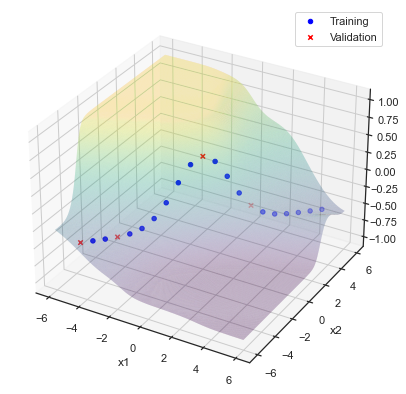

The MSE on the train set is 0.0087, and on the validation set it is 0.0155.


In [36]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train, y_train, X_val, y_val, 25, 0.2, max_iterations=max_iter)
mse_val.append(error_val)
mse_train.append(error_train)

#### Comparison

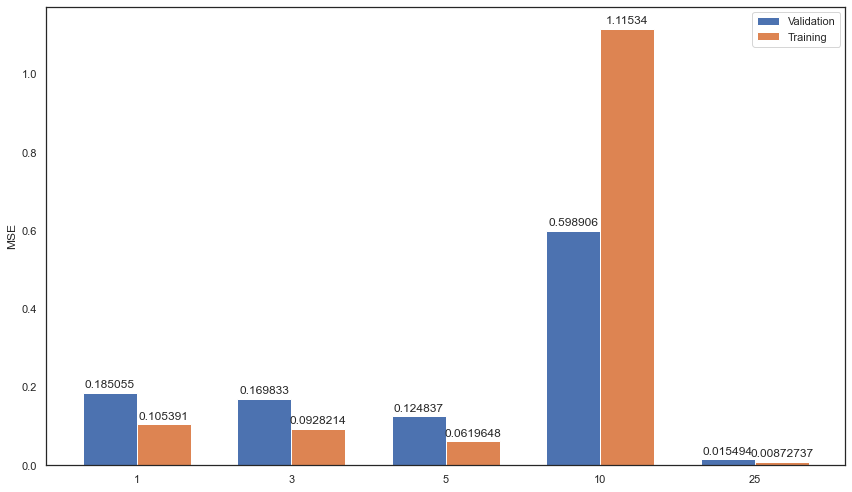

In [37]:
labels = ['1', '3', '5', '10', '25']

plot_final_errors_per_run(
  mse_val, mse_train, labels=labels, metric="MSE",
  path='{}tlp_function_approx_errors_per_split_mse_v_20_batch.png'.format(img_path)
)

### 2. Best Model
For the selected ”best” model with respect to the number of hidden nodes,
compare the original configuration with 80% against the one with 20%
training samples. How sensitive is the generalization to a training data
subset (the actual subsets randomly sampled for training)? Do you think
it matters which part of the input space training data happens to come
from?

#### 20% Training 80% Validation

In [38]:
X_train_1, y_train_1, X_val_1, y_val_1 = train_val_split(X, y_true, validation_fraction=0.8)

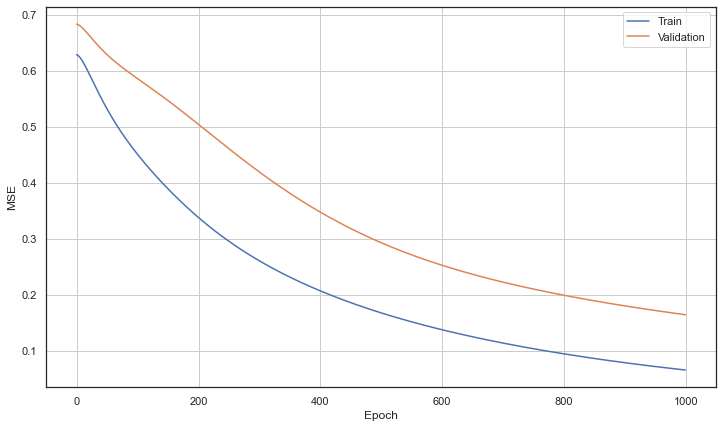

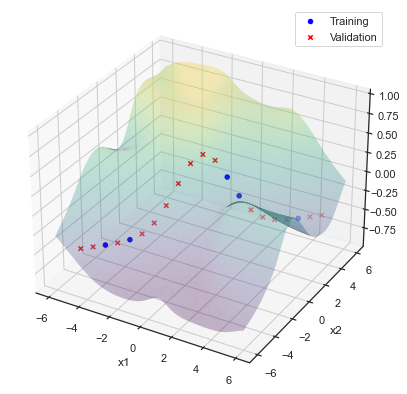

The MSE on the train set is 0.0653, and on the validation set it is 0.1641.


In [39]:
error_train, error_val = run_experiment_with_validation_func_approx(X_train_1, y_train_1, X_val_1, y_val_1, 25, 0.2, max_iterations=max_iter)

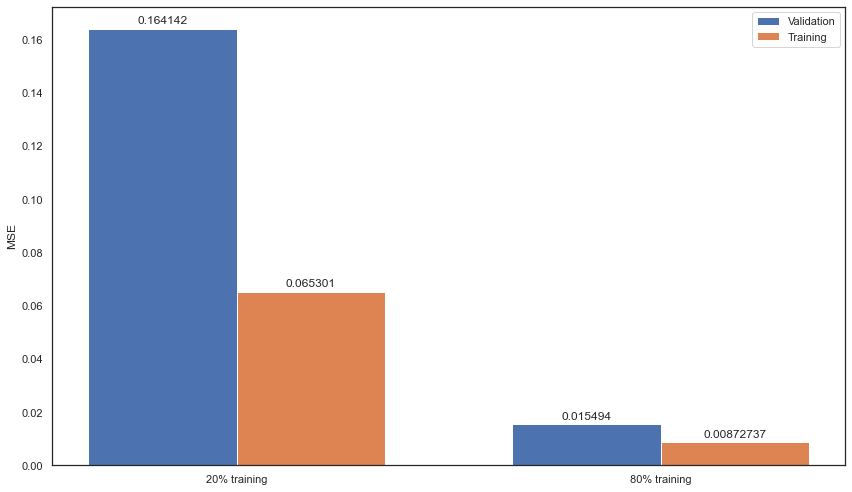

In [41]:
plot_final_errors_per_run(
  [error_val, mse_val[-1]], [error_train, mse_train[-1]], labels=['20% training', '80% training' ], metric="MSE",
  path='{}tlp_function_approx_errors_per_split_mse_v_20_v_80_batch.png'.format(img_path)
)